# Capstone Project
## Credit Card Fraud Detection


### Data Loading & Pre processing

In [24]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection  import train_test_split,KFold, cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,\
recall_score,classification_report,accuracy_score,precision_score,f1_score,make_scorer,average_precision_score
from imblearn.over_sampling import SMOTE
from time import time
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
import seaborn as sns
import disp_plot
from matplotlib.colors import ListedColormap
import imp
%matplotlib inline

In [2]:
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [20]:
normal_trans_perc=sum(data['Class']==0)/(sum(data['Class']==0)+sum(data['Class']==1))
fraud_trans_perc=1-normal_trans_perc
print('Total number of records : {} '.format(len(data)))
print('Total number of normal transactions : {}'.format(sum(data['Class']==0)))
print('Total number of  fraudulent transactions : {}'.format(sum(data['Class']==1)))
print('Percent of normal transactions is : {:.4f}%,  fraudulent transactions is : {:.4f}%'.format(normal_trans_perc*100,fraud_trans_perc*100))

Total number of records : 284807 
Total number of normal transactions : 284315
Total number of  fraudulent transactions : 492
Percent of normal transactions is : 99.8273%,  fraudulent transactions is : 0.1727%


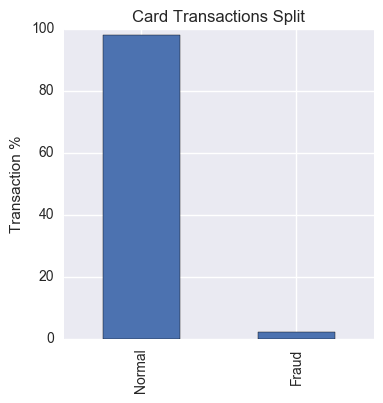

In [118]:
plt.figure(figsize=(4, 4))
cards_trans_count= pd.Series([normal_trans_perc*100,fraud_trans_perc*100],index=['Normal','Fraud'])
cards_trans_count.plot(kind='bar', title='Card Transactions Split')
plt.ylabel('Transaction %')

### Normalizing 

In [3]:
data['NormAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,NormAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


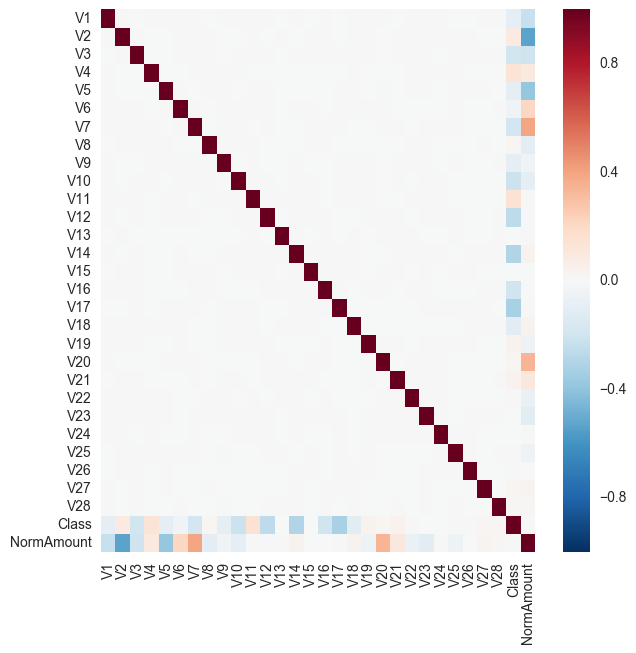

In [22]:
fig, ax = plt.subplots(figsize=(7,7))  
sns.heatmap(data.corr(),annot_kws={"size":4})

In [4]:
X_raw = data.ix[:, data.columns != 'Class']
y_raw = data.ix[:, data.columns == 'Class']

In [5]:
#Drop columns low correlaction score
X=X_raw.drop(['V22','V23','V24','V25','V26','V27','V28'], axis = 1)
y=y_raw

### Split into train and test data

In [6]:
# Split into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

In [26]:
#Stats of training data 
print('---------Training data statistics-----------')
normal_trans_perc=sum( y_train['Class']==0)/(sum( y_train['Class']==0)+sum( y_train['Class']==1))
fraud_trans_perc=1-normal_trans_perc
print('Total number of records : {} '.format(len(y_train)))
print('Total number of normal transactions : {}'.format(sum(y_train['Class']==0)))
print('Total number of  fraudulent transactions : {}'.format(sum(y_train['Class']==1)))
print('Percent of normal transactions is : {:.4f}%,  fraudulent transactions is : {:.4f}%'.format(normal_trans_perc*100,fraud_trans_perc*100))

---------Training data statistics-----------
Total number of records : 199364 
Total number of normal transactions : 199019
Total number of  fraudulent transactions : 345
Percent of normal transactions is : 99.8269%,  fraudulent transactions is : 0.1731%


In [27]:
#Stats of testing data 
print('---------Testing data statistics-----------')
normal_trans_perc=sum( y_test['Class']==0)/(sum( y_test['Class']==0)+sum( y_test['Class']==1))
fraud_trans_perc=1-normal_trans_perc
print('Total number of records : {} '.format(len(y_test)))
print('Total number of normal transactions : {}'.format(sum(y_test['Class']==0)))
print('Total number of  fraudulent transactions : {}'.format(sum(y_test['Class']==1)))
print('Percent of normal transactions is : {:.4f}%,  fraudulent transactions is : {:.4f}%'.format(normal_trans_perc*100,fraud_trans_perc*100))

---------Testing data statistics-----------
Total number of records : 85443 
Total number of normal transactions : 85296
Total number of  fraudulent transactions : 147
Percent of normal transactions is : 99.8280%,  fraudulent transactions is : 0.1720%


### Resampling of data using SMOTE Technique 

In [7]:
sm = SMOTE(ratio=.02,kind='borderline1',random_state=0)

In [8]:
X_resampled_train, y_resampled_train = sm.fit_sample(X_train, y_train.values.ravel())

In [9]:
## Convert to dataframe
X_resampled_train=pd.DataFrame(X_resampled_train,columns=
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 
 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'NormAmount'])
y_resampled_train=pd.DataFrame(y_resampled_train,columns=['Class'])

In [31]:
print('---------------Resampled data statistics---------------')
normal_trans_perc=sum(y_resampled_train['Class']==0)/(sum(y_resampled_train['Class']==0)+sum(y_resampled_train['Class']==1))
fraud_trans_perc=1-normal_trans_perc
print('Total number of records : {} '.format(len(y_resampled_train)))
print('Total number of normal transactions : {}'.format(sum(y_resampled_train['Class']==0)))
print('Total number of  fraudulent transactions : {}'.format(sum(y_resampled_train['Class']==1)))
print('Percent of normal transactions is : {:.4f}%,  fraudulent transactions is : {:.4f}%'.format(normal_trans_perc*100,fraud_trans_perc*100))

---------------Resampled data statistics---------------
Total number of records : 202999 
Total number of normal transactions : 199019
Total number of  fraudulent transactions : 3980
Percent of normal transactions is : 98.0394%,  fraudulent transactions is : 1.9606%


In [38]:
X_resampled_train.to_csv('x_train.csv')
y_resampled_train.to_csv('y_train.csv')
X_test.to_csv('x_test.csv')
y_test.to_csv('y_test.csv')

### Model Building & Initial Metrics ###

In [10]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on       
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
   
    start = time() # Get start time
    learner.fit(X_train, y_train)
    end = time() # Get end time
      
    results['train_time'] = end - start
        
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    
    predictions_test_prob = learner.predict_proba(X_test)[:,1]
    predictions_train_prob = learner.predict_proba(X_train)[:,1]
    
    
    end = time() # Get end time
        
    results['pred_time'] =end - start
            
    
    results['acc_train'] = accuracy_score(y_train, predictions_train)      
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    results['rec_train'] = recall_score(y_train, predictions_train)      
    results['rec_test'] = recall_score(y_test, predictions_test)
    
    results['prec_train'] = precision_score(y_train, predictions_train)      
    results['prec_test'] = precision_score(y_test, predictions_test)
    
    
    results['f1_train'] = f1_score(y_train, predictions_train)
    results['f1_test'] = f1_score(y_test, predictions_test)
    
    results['auc_train'] = average_precision_score(y_train, predictions_train_prob,average='weighted')
    results['auc_test'] = average_precision_score(y_test, predictions_test_prob,average='weighted')
    
    
       
    # Success
    print("{} trained in time {:.4f} ".format(learner.__class__.__name__,(end - start)))
        
    # Return the results
    return results

In [108]:
# Initialize and train the models
clf_lr = LogisticRegression(random_state=0)
clf_rf = RandomForestClassifier(random_state=0)
clf_ab = AdaBoostClassifier(random_state=0)
clf_xg = XGBClassifier()

# Collect results on the learners
results = {}
for clf in [clf_lr, clf_ab,clf_rf,clf_xg]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = train_predict(clf, X_resampled_train, y_resampled_train.values.ravel(), X_test, y_test.values.ravel())


LogisticRegression trained in time 0.1491 
AdaBoostClassifier trained in time 21.4644 
RandomForestClassifier trained in time 2.7736 
XGBClassifier trained in time 1.6752 


In [109]:
lr_res=pd.DataFrame(results['LogisticRegression'],index=['LR'])
ab_res=pd.DataFrame(results['AdaBoostClassifier'],index=['AB'])
rf_res=pd.DataFrame(results['RandomForestClassifier'],index=['RF'])
xg_res=pd.DataFrame(results['XGBClassifier'],index=['XG'])
all_res= pd.concat([lr_res,rf_res,ab_res,xg_res])

In [110]:
##Untuned Classifiers scores
all_res[['train_time','pred_time','acc_train','acc_test','rec_train','rec_test',\
         'prec_train','prec_test','f1_train','f1_test','auc_train','auc_test']]

,train_time,pred_time,acc_train,acc_test,rec_train,rec_test,prec_train,prec_test,f1_train,f1_test,auc_train,auc_test
LR,11.220418,0.149099,0.996601,0.999064,0.868593,0.809524,0.953918,0.695906,0.909258,0.748428,0.946210,0.743391
RF,50.579490,2.773643,0.999926,0.999579,0.996482,0.809524,0.999748,0.937008,0.998112,0.868613,0.999997,0.836311
AB,194.903737,21.464434,0.997330,0.998783,0.913568,0.789116,0.948357,0.613757,0.930637,0.690476,0.978190,0.768222
XG,39.393790,1.675158,0.998675,0.999333,0.953266,0.829932,0.978592,0.792208,0.965763,0.810631,0.991087,0.806329


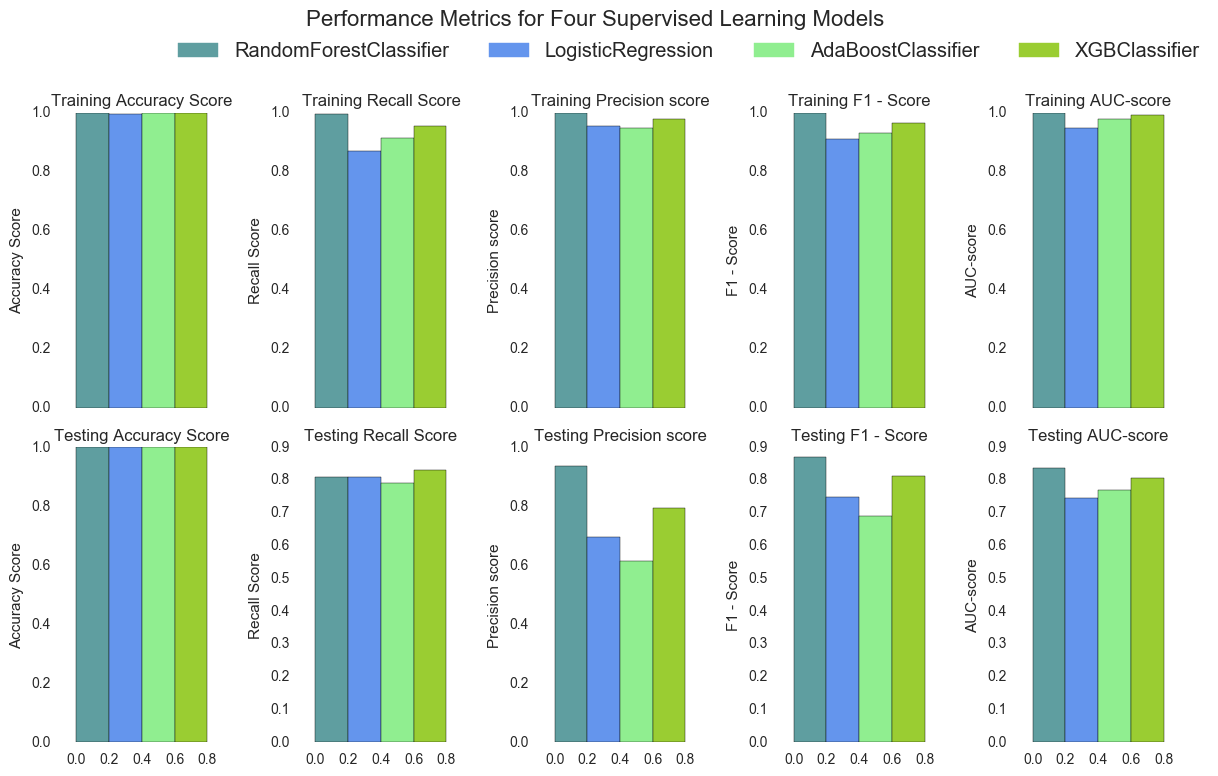

In [111]:
imp.reload(disp_plot)
disp_plot.evaluate(results)

### XGBOOST Model Tuning 

In [36]:
def XGB_class_tune(clf,param_set1):
    start = time() # Get start time    
    scorer = make_scorer(recall_score,average='weighted')
    grid_obj = GridSearchCV(estimator=clf, param_grid=param_set1, scoring=scorer,cv=5)

    grid_fit = grid_obj.fit(X_resampled_train, y_resampled_train.values.ravel())

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_resampled_train, y_resampled_train.values.ravel())).predict(X_test)
    predictions_prob = clf.predict_proba(X_test)[:,1]

    best_predictions = best_clf.predict(X_test)
    best_predictions_prob = best_clf.predict_proba(X_test)[:,1]


    # Report the before-and-afterscores
    print("Earlier model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("F1-score on testing data: {:.4f}".format(f1_score(y_test, predictions)))
    print("recall on testing data: {:.4f}".format(recall_score(y_test, predictions)))
    print("precision on testing data: {:.4f}".format(precision_score(y_test, predictions)))    
    print("Precision recall auc on testing data: {:.4f}".\
          format(average_precision_score(y_test, predictions_prob,average='weighted')))

    print("\nNew Model\n------")
    print("accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("F1-score on the testing data: {:.4f}".format(f1_score(y_test, best_predictions)))
    print("Recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions)))
    print("precision on testing data: {:.4f}".format(precision_score(y_test, best_predictions)))    
    print("Precision recall auc on testing data: {:.4f}".\
          format(average_precision_score(y_test, best_predictions_prob,average='weighted')))

    end = time() # Get end time
    # show best parameters
    print("\nNew Classifier\n------")
    print(best_clf)
    print('time taken',end-start)

In [37]:
#Tuning level 1
clf = XGBClassifier()
param_set1 = {'max_depth': (8, 10)}
XGB_class_tune(clf,param_set1)

Earlier model
------
Accuracy score on testing data: 0.9993
F1-score on testing data: 0.8106
recall on testing data: 0.8299
precision on testing data: 0.7922
Precision recall auc on testing data: 0.8063

New Model
------
accuracy score on the testing data: 0.9996
F1-score on the testing data: 0.8643
Recall score on the testing data: 0.8231
precision on testing data: 0.9098
Precision recall auc on testing data: 0.8424

New Classifier
------
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
time taken 767.8060235977173


In [39]:
#Tuning level 2
clf = XGBClassifier(max_depth=8)
param_set1 = {'min_child_weight':(2,4)}
XGB_class_tune(clf,param_set1)

Earlier model
------
Accuracy score on testing data: 0.9996
F1-score on testing data: 0.8643
recall on testing data: 0.8231
precision on testing data: 0.9098
Precision recall auc on testing data: 0.8424

New Model
------
accuracy score on the testing data: 0.9996
F1-score on the testing data: 0.8746
Recall score on the testing data: 0.8299
precision on testing data: 0.9242
Precision recall auc on testing data: 0.8434

New Classifier
------
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
time taken 777.4652435779572


In [40]:
#Tuning level 3
clf = XGBClassifier(max_depth=8,min_child_weight=2)
param_set1 = {'reg_lambda': (0.391, 0.395, 0.399)}
XGB_class_tune(clf,param_set1)

Earlier model
------
Accuracy score on testing data: 0.9996
F1-score on testing data: 0.8746
recall on testing data: 0.8299
precision on testing data: 0.9242
Precision recall auc on testing data: 0.8434

New Model
------
accuracy score on the testing data: 0.9995
F1-score on the testing data: 0.8500
Recall score on the testing data: 0.8095
precision on testing data: 0.8947
Precision recall auc on testing data: 0.8457

New Classifier
------
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=0.391,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
time taken 1084.1649446487427


In [41]:
#Tuning level 4
clf = XGBClassifier(max_depth=8,min_child_weight=2)
param_set1 = {'n_estimators': (150,200)}
XGB_class_tune(clf,param_set1)

Earlier model
------
Accuracy score on testing data: 0.9996
F1-score on testing data: 0.8746
recall on testing data: 0.8299
precision on testing data: 0.9242
Precision recall auc on testing data: 0.8434

New Model
------
accuracy score on the testing data: 0.9996
F1-score on the testing data: 0.8736
Recall score on the testing data: 0.8231
precision on testing data: 0.9308
Precision recall auc on testing data: 0.8491

New Classifier
------
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
time taken 1184.4662945270538


## Model Comparison Between Pre & Post Tuned Models(Test Data)

### Comparison Between Pre & Post Tuned XGB Models(Test Data)


In [ ]:
clf_pre_tune = XGBClassifier()
##Final Tuned XGB Model
clf_post_tune = XGBClassifier(max_depth=8,min_child_weight=2)
results_tune={}
results_tune['XG-PRE-TUNE'] = {}
results_tune['XG-PRE-TUNE'] = train_predict(clf_pre_tune, X_resampled_train, y_resampled_train.values.ravel(), X_test, y_test.values.ravel())
results_tune['XG-POST-TUNE'] = {}
results_tune['XG-POST-TUNE'] = train_predict(clf_post_tune, X_resampled_train, y_resampled_train.values.ravel(), X_test, y_test.values.ravel())

xg_pre_tune=pd.DataFrame(results_tune['XG-PRE-TUNE'],index=['XG-PRE-TUNE'])
xg_post_tune=pd.DataFrame(results_tune['XG-POST-TUNE'],index=['XG-POST-TUNE'])
all_res= pd.concat([xg_pre_tune,xg_post_tune])

all_res[['acc_train','acc_test','rec_train','rec_test',\
         'prec_train','prec_test','f1_train','f1_test','auc_train','auc_test']]



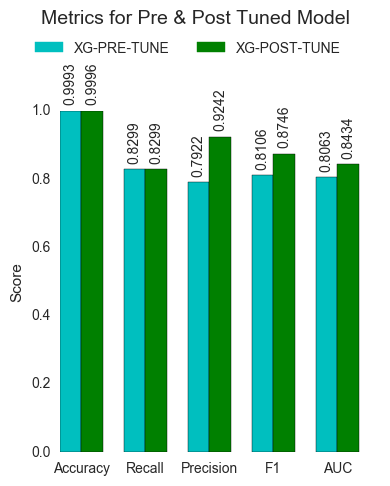

In [99]:
imp.reload(disp_plot)
disp_plot.comp_stats(results_tune)

### Comparison Between Post Tuned - XGB & RandomForest Classifier(Test Data)

In [16]:
## Referred from Random Forest Tuning Notebook
clf_post_tune_rf = RandomForestClassifier(random_state=0,max_depth=20,min_samples_leaf=5)
##Final Tuned XGB Model
clf_post_tune_xgb = XGBClassifier(max_depth=8,min_child_weight=2)
results_tune_1={}
results_tune_1['RF-POST-TUNE'] = {}
results_tune_1['RF-POST-TUNE'] = train_predict(clf_post_tune_rf, X_resampled_train, y_resampled_train.values.ravel(), X_test, y_test.values.ravel())
results_tune_1['XG-POST-TUNE'] = {}
results_tune_1['XG-POST-TUNE'] = train_predict(clf_post_tune_xgb, X_resampled_train, y_resampled_train.values.ravel(), X_test, y_test.values.ravel())

rf_post_tune_1=pd.DataFrame(results_tune_1['RF-POST-TUNE'],index=['RF-POST-TUNE'])
xg_post_tune_1=pd.DataFrame(results_tune_1['XG-POST-TUNE'],index=['XG-POST-TUNE'])
all_res_1= pd.concat([rf_post_tune_1,xg_post_tune_1])

all_res_1[['acc_train','acc_test','rec_train','rec_test',\
         'prec_train','prec_test','f1_train','f1_test','auc_train','auc_test']]


RandomForestClassifier trained in time 2.8283 
XGBClassifier trained in time 1.7188 


,acc_train,acc_test,rec_train,rec_test,prec_train,prec_test,f1_train,f1_test,auc_train,auc_test
RF-POST-TUNE,0.999675,0.999508,0.987186,0.823129,0.996197,0.883212,0.991671,0.852113,0.999478,0.832340
XG-POST-TUNE,0.999897,0.999590,0.994975,0.829932,0.999748,0.924242,0.997355,0.874552,0.999656,0.843394


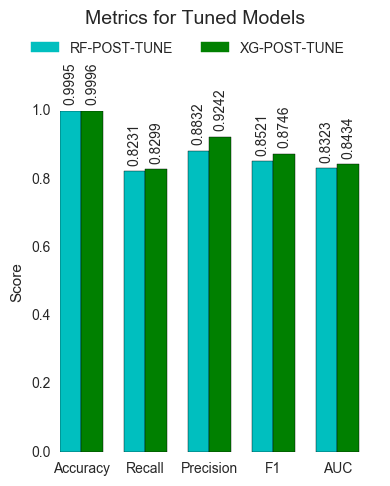

In [18]:
imp.reload(disp_plot)
disp_plot.comp_stats(results_tune_1)

### Comparison Between Benchmark(Logistic Regression) & Tuned XGB Model(Test Data)

In [22]:
clf_post_tune_bm = LogisticRegression(random_state=0)
##Final Tuned XGB Model
clf_post_tune_xgb = XGBClassifier(max_depth=8,min_child_weight=2)
results_tune_2={}
results_tune_2['Benchmark'] = {}
results_tune_2['Benchmark'] = train_predict(clf_post_tune_bm, X_resampled_train, y_resampled_train.values.ravel(), X_test, y_test.values.ravel())
results_tune_2['XG-POST-TUNE'] = {}
results_tune_2['XG-POST-TUNE'] = train_predict(clf_post_tune_xgb, X_resampled_train, y_resampled_train.values.ravel(), X_test, y_test.values.ravel())

bm_post_tune_2=pd.DataFrame(results_tune_2['Benchmark'],index=['Benchmark'])
xg_post_tune_2=pd.DataFrame(results_tune_2['XG-POST-TUNE'],index=['XG-POST-TUNE'])
all_res_2= pd.concat([bm_post_tune_2,xg_post_tune_2])

all_res_2[['acc_train','acc_test','rec_train','rec_test',\
         'prec_train','prec_test','f1_train','f1_test','auc_train','auc_test']]


LogisticRegression trained in time 0.1250 
XGBClassifier trained in time 1.9845 


,acc_train,acc_test,rec_train,rec_test,prec_train,prec_test,f1_train,f1_test,auc_train,auc_test
Benchmark,0.996601,0.999064,0.868593,0.809524,0.953918,0.695906,0.909258,0.748428,0.946210,0.743391
XG-POST-TUNE,0.999897,0.999590,0.994975,0.829932,0.999748,0.924242,0.997355,0.874552,0.999656,0.843394


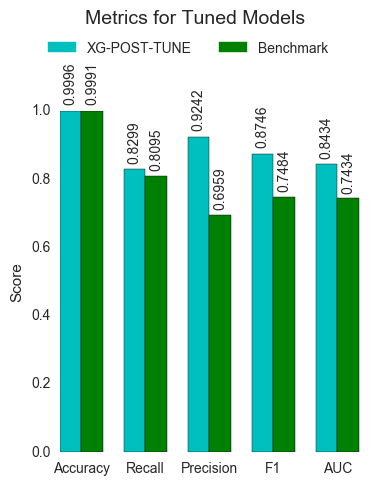

In [25]:
imp.reload(disp_plot)
disp_plot.comp_stats(results_tune_2)

### Features Importance Chart

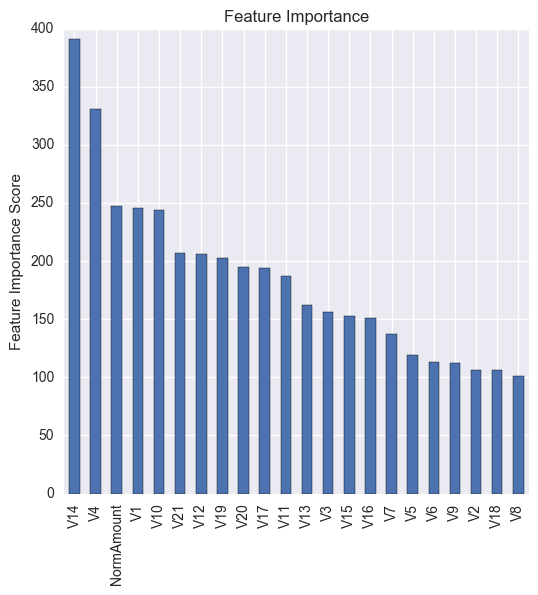

In [95]:
# feature importance
plt.figure(figsize=(6, 6))
feature_importance = pd.Series(clf_post_tune.booster().get_fscore()).sort_values(ascending=False)
feature_importance.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')
plt.savefig('Feature Importance.png')